1. REGRESIÓN LINEAL REGULARIZADA

1. Incluimos las bibliotecas necesarias

In [467]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import pandas as pd
from scipy.optimize import minimize

2. Cargamos los datos

In [470]:
data = loadmat('C:/Users/carli_000/Desktop/AA/ex5data1.mat')
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
Xtest = data['Xtest']
ytest = data['ytest']


In [471]:
#inserto columna de unos
X_unos = np.insert(X, 0, 1, axis=1)
theta = np.array([[1], [1]])
Xval_unos =  np.insert(Xval, 0, 1, axis=1)


3. Se calcula el coste y el gradiente según la fórmula

In [472]:
def costeGradiente(X,y, theta, landa):
    m=len(X)
    theta = theta.reshape(-1, y.shape[1])
    #COSTE
    coste1 = (np.sum(np.power(np.dot(X,theta)-y,2)))/(2*m)
    coste2 = coste1 + (landa/(2*m))* (np.sum(np.power(theta[1:len(theta)],2)))
    #GRADIENTE
    #para j = 0
    grad = (1 / m) * np.dot(X.T, np.dot(X, theta) - y) + (landa/ m ) * theta
    
    # j=0
    unreg_grad = (1 / m) * np.dot(X.T, np.dot(X, theta) - y)
    grad[0] = unreg_grad[0]
    return coste2, grad.flatten()



In [473]:
coste, degr = costeGradiente(X_unos, y, theta, 1)
print('Coste: %f\n' % coste)
print('Degradación:')
print(degr)

Coste: 303.993192

Degradación:
[-15.30301567 598.25074417]


Hacemos uso de scipy.optimize.minimize para encontrar el valor de que minimiza el error sobre los ejemplos de entrenamiento

In [446]:

def entrenamiento(X,y, landa):
    theta_inicial = np.zeros((X.shape[1], 1))
    def costFunction(theta):
        return costeGradiente(X, y, theta, landa)
    result = minimize(fun=costFunction,
                       x0=theta_inicial,
                       method='CG',
                       jac=True,
                       options={'maxiter':200})
    theta_min= result.x
   

    return theta_min
theta_min = entrenamiento(X_unos, y,1)


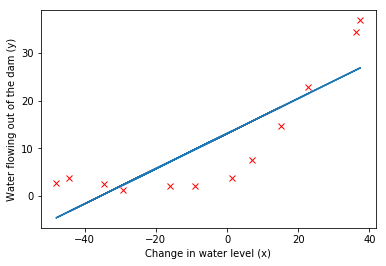

In [447]:
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.plot(X, y, 'rx')
plt.plot(X, np.dot(np.insert(X, 0, 1, axis=1), theta_min))

2. CURVAS DE APRENDIZAJE


Para generar curvas de aprendizaje repetimos el entrenamiento por regresión lineal
del apartado anterior, utilizando diferentes subconjuntos de los datos de entrenamiento

In [448]:
def curvaAprendizaje(X, y, Xval, yval, landa):
    m= len(X)
    error_entrenamiento= np.zeros((m,1))
    error_val= np.zeros((m,1))
    
    for i in range(0, m):
        theta = entrenamiento(X[0:i+1], y[0:i+1], landa)
        
        error_entrenamiento[i] = costeGradiente(X[0:i+1], y[0:i+1], theta,landa)[0]
        error_val[i]=costeGradiente(Xval, yval, theta, landa)[0]
    return error_entrenamiento, error_val
error_entrenamiento, error_val = curvaAprendizaje(X_unos, y,Xval_unos, yval, 1)

De esta forma, obtenemos m valores para el error sobre los subconjuntos de los ejemplos de
entrenamiento y el error sobre los ejemplos de validación

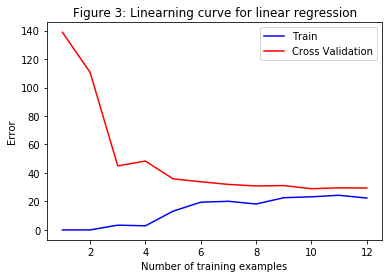

In [449]:
m = len(X)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Figure 3: Linearning curve for linear regression')
plt.plot(range(1,m+1), error_entrenamiento, 'b', label='Train', color='b')
plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation', color ='r')
plt.legend()

Este metodo nos ayuda a saber si el aprendizaje está sesgado. En este caso estamos ante un caso de sesgo ya que al aumentar el número de ejemplos de entrenamiento, la curva de error se acerca a la propia curva del número de ejemplos de entrenamiento.

3. REGRESION POLINOMIAL

In [450]:
def nuevosEntrenamientos(X, p):
    X_nueva = X
    for i in range(1,p):
        X_nueva = np.column_stack((X_nueva, np.power(X,i+1)))
    return X_nueva


Como se introducirán grandes diferencias de rango hay que normalizar los atributos antes de realizar el aprendizaje de theta. Para ello implementamos la siguiente función:

In [451]:
def normalizada(X):
    
    mu = np.mean(X, axis=0)
    X_normalizada = X - mu
    
    sigma = np.std(X_normalizada, axis=0)
    X_normalizada = X_normalizada/sigma
    
    return X_normalizada, mu, sigma


In [452]:
p = 8
#obtenemos los nuevos datos de entrenamiento
X_nueva = nuevosEntrenamientos(X,p)
#normalizamos esos datos
X_nueva, mu, sigma = normalizada(X_nueva)
#añadimos una columna de 1's a estos nuevos datos
X_nueva = np.insert(X_nueva,0,1,axis=1)

X_nueva_val = nuevosEntrenamientos(Xval, p)
X_nueva_val = X_nueva_val - mu
X_nueva_val = X_nueva_val / sigma
X_nueva_val = np.insert(X_nueva_val, 0, 1, axis=1)

In [453]:
theta = entrenamiento(X_nueva, y, 0)

In [454]:
def pintaRegresionPolinomial(x_min, x_max, mu, sigma, theta, p):
    x = np.array(np.arange(x_min - 15, x_max + 25, 0.05))
    X_nueva = nuevosEntrenamientos(x, p)
    X_nueva = X_nueva - mu
    X_nueva = X_nueva / sigma

    X_nueva = np.insert(X_nueva, 0, 1, axis=1)

    plt.plot(x, np.dot(X_nueva, theta), '--')

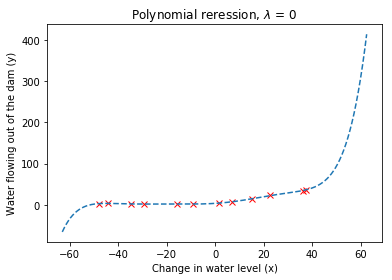

In [455]:

plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial reression, $\lambda$ = 0')
plt.plot(X, y, 'rx')

pintaRegresionPolinomial(min(X), max(X), mu, sigma, theta, p)


Generamos curvas de aprendizaje para la hipótesis polinomial. Aplicamos la regresión a subconjuntos
cada vez mayores de los datos de entrenamiento y evaluamos el error de la hipótesis aprendida
sobre ese subconjunto y un conjunto independiente de ejemplos de validación.

In [456]:
# X_nueva_val = nuevosEntrenamientos(Xval, p)
# X_nueva_val = X_nueva_val - mu
# X_nueva_val = X_nueva_val / sigma
# X_nueva_val = np.insert(X_nueva_val, 0, 1, axis=1)

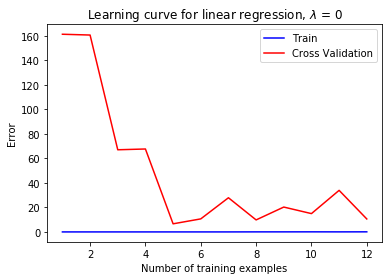

In [457]:
error_entrenamiento, error_val = curvaAprendizaje(X_nueva, y, X_nueva_val, yval, 0)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression, $\lambda$ = 0')
plt.plot(range(1,m+1), error_entrenamiento, 'b', label='Train')
plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation', color='r')
plt.legend()

Para landa = 0 el error es 0

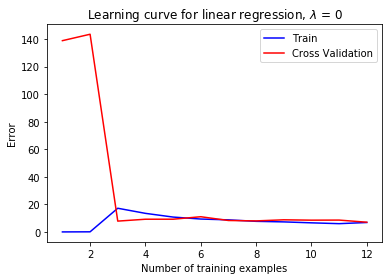

In [458]:
error_entrenamiento, error_val = curvaAprendizaje(X_nueva, y, X_nueva_val, yval, 1)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression, $\lambda$ = 0')
plt.plot(range(1,m+1), error_entrenamiento, 'b', label='Train')
plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation', color='r')
plt.legend()

Para landa = 1 el error es similar al obtenido con landa = 0

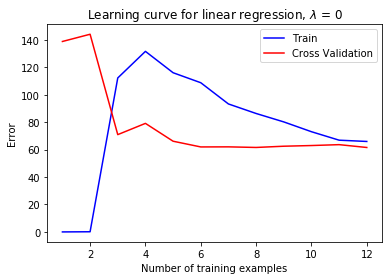

In [459]:
error_entrenamiento, error_val = curvaAprendizaje(X_nueva, y, X_nueva_val, yval, 100)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression, $\lambda$ = 0')
plt.plot(range(1,m+1), error_entrenamiento, 'b', label='Train')
plt.plot(range(1,m+1), error_val, 'g', label='Cross Validation', color='r')
plt.legend()

Para landa = 100, el error aumenta a medida que el cross validation disminuye

4. Selección del parámetro landa

La técnica que se suele utilizar para elegir el valor de  es evaluar la hipótesis generada sobre
los ejemplos de entrenamiento con un segundo conjunto de ejemplos de validación y seleccionar
aquél valor de  que minimice el error.

In [460]:
def errorLanda(X, y, Xval, yval):
    landa = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    tamLanda = len(landa)
    error_entrenamiento = np.zeros((tamLanda, 1))
    error_val = np.zeros((tamLanda, 1))

    for i in range(tamLanda):
        landa_aux = landa[i]
        theta = entrenamiento(X, y, landa_aux)
        #obtenemos el error de cada landa
        error_entrenamiento[i] = costeGradiente(X, y, theta, 0)[0]
        error_val[i] = costeGradiente(Xval, yval, theta, 0)[0]
         
    return landa, error_entrenamiento, error_val


In [461]:
landa_aux, error_entrenamiento, error_val = errorLanda(X_nueva, y, X_nueva_val, yval)

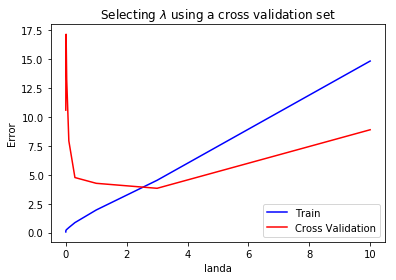

In [462]:
plt.xlabel('landa')
plt.ylabel('Error')
plt.title('Selecting $\lambda$ using a cross validation set')
plt.plot(landa_aux, error_entrenamiento, 'b', label='Train')
plt.plot(landa_aux, error_val, 'g', label='Cross Validation',color='r')

plt.legend()


In [463]:
X_nueva_test = nuevosEntrenamientos(Xtest, p)
X_nueva_test = X_nueva_test - mu
X_nueva_test = X_nueva_test / sigma
X_nueva_test = np.insert(X_nueva_test, 0, 1, axis=1)

Probamos con landa = 3 para ver si el error de test es el correcto.

In [465]:
theta = entrenamiento(X_nueva, y, 3)
error_test = costeGradiente(X_nueva_test, ytest, theta, 0)[0]
print('El mejor test error para landa es: %f\n' % error_test)

El mejor test error para landa es: 3.572027



Hao Hao He y Carla Paola Peñarrieta Uribe